<a href="https://colab.research.google.com/github/Ch4mi7h/Py_ImageProcessing/blob/main/GroupD_PP_As1_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Estimating Paricle Parametrs using Image processing**


Objectives:  extract the following details,

*  Number of particles
*   Particle size, sphericity (circularity in 2D) distribution
*   Average particle size List item

According to given example image,the unit conversion taken as  1mm = 1.82 px



##Initiation of Notebook

Import stuff and mount with source

In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 5.0 MB/s 


In [ ]:
pip install pillow

In [ ]:
#Upload Required python pacakages and libraries 

import math
import pydicom
import pandas as pd
import PIL
from PIL import Image , ImageFilter

import pydicom.data
import numpy as np
import skimage.exposure

import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
#maount with my Google Drive

from os import chdir
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Dicom image convertion and pre-processing

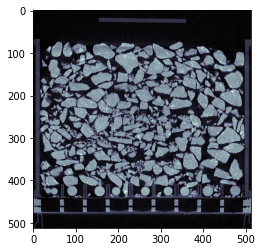

In [ ]:
 #Open/ Dispaly the dcm file,  
#ds = pydicom.dcmread(filename)
ds = pydicom.dcmread('/content/drive/MyDrive/PlantPerform_A01/Final/GroupD.dcm')

  
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)  # set the color map and show the dicom 
#plt.show()

In [ ]:
#Convert dcm to jpg (done)
#Crope the Image (done)
#Extract number of particles
#Estimate parameters
#Avg PS est.

In [ ]:
#Convert dicom to jpg format (pydicom and np)

ds = pydicom.dcmread('/content/drive/MyDrive/PlantPerform_A01/Final/GroupD.dcm')

new_image = ds.pixel_array.astype(float)


scaled_image = (np.maximum(new_image, 0) / new_image.max())*255.0

scaled_image = np.uint8(scaled_image)
final_image = Image.fromarray(scaled_image)



In [ ]:
final_image.save('/content/drive/MyDrive/PlantPerform_A01/Final/GroupD.jpg')



In [ ]:
#Display the crated jpg image (512*512, using PIL)

#from IPython.display import Image
#Image(filename='/content/drive/MyDrive/PlantPerform_A01/Final/GroupD.jpg', width=512,height=512)

(512, 512, 3)


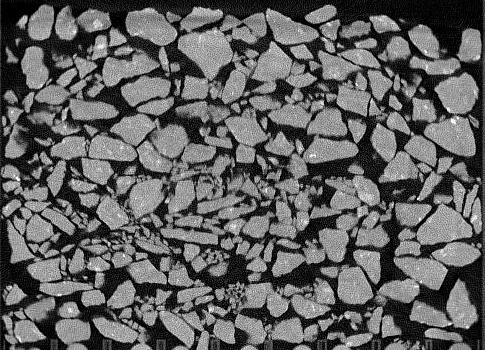

Cropped image 



True

In [ ]:
#Crop the Jpg as all minerals include (Using OpenCV)


img = cv2.imread('/content/drive/MyDrive/PlantPerform_A01/Final/GroupD.jpg')
print(img.shape) # Print image shape
#cv2_imshow(img)

#print('Original image \n')

# Cropping an image
#y:y+h, x:x+w, the pixels from 70 to 420 (ydir) and 15 to 500 (xdir) is extracting
cropped_image = img[70:420,15:500]
# Display cropped image 
cv2_imshow(cropped_image)

print('Cropped image \n')

#Save cropped image

cv2.imwrite('/content/drive/MyDrive/PlantPerform_A01/Final/Crop_GroupD.jpg', cropped_image)



##The JPG image Processing ( grayscale, Blurring etc.)

In [ ]:
#Extract number of particles

cp_img =cv2.imread('/content/drive/MyDrive/PlantPerform_A01/Final/Crop_GroupD.jpg')


#Test 01 - procedure 
#convert to grayscale, apply image burrer, extract edges etc. then find a trained model to cpounting or make amodel to counting

#01 cov grascale

gray_img = cv2.cvtColor(cp_img, cv2.COLOR_BGR2GRAY) 
#cv2_imshow(gray_img)

print('Gray Image \n')

#02 Blurring 1. Gaussing (not working) , 2. Median Blur

#blur_img = cv2.GaussianBlur(gray_img, (7,7), 0)
blur_img = cv2.medianBlur(gray_img,3)
#cv2_imshow(blur_img)

print('Blurred Image \n')

#03 Detect edges 

edg_img = cv2.Canny(blur_img,100,200)
#cv2_imshow(edg_img)

print('Detected edges of Image \n')


Gray Image 

Blurred Image 

Detected edges of Image 



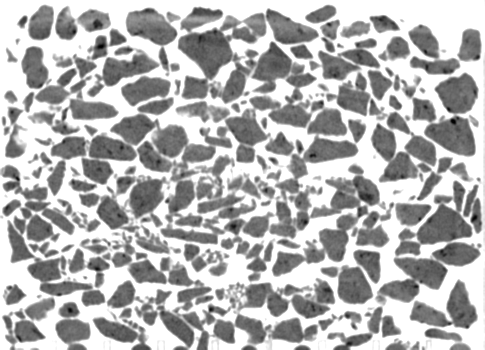

In [ ]:
# reduce noice and adjust he exposure

# blur threshold image
temp0 = cv2.GaussianBlur(gray_img, (0,0), sigmaX=1, sigmaY=1, borderType = cv2.BORDER_DEFAULT)
temp1 = cv2.bitwise_not(temp0)
#result =blur

# stretch so that 160 -> 255 and 70 -> 0
# C = A*X+B # calc error//
# 255 = A*160+B
# 0 = A*225+B
# Thus A=2 and B=-127.5
#aa = a*2.0-255.0 does not work correctly, so use skimage
result = skimage.exposure.rescale_intensity(temp1, in_range=(30,200), out_range=(0,255)).astype(np.uint8)
cv2_imshow(result)


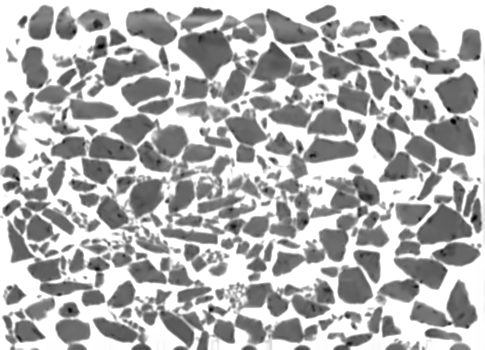

Preporcessed image


In [ ]:
#Reduce noice

Cor_img =result
#Cor_img = cv2.bitwise_not(result)
#Cor_img = cv2.bitwise_not(gray_img)
temp = cv2.fastNlMeansDenoising(Cor_img,2,8)
#inv_img= cv2.medianBlur(temp,3)
inv_img= temp

#cv2_imshow(result)
#cv2_imshow(Cor_img)
cv2_imshow(inv_img)
print('Preporcessed image')

#cv2.imwrite('/content/drive/MyDrive/PlantPerform_A01/Corr_edge_samp1.jpg', Cor_img)

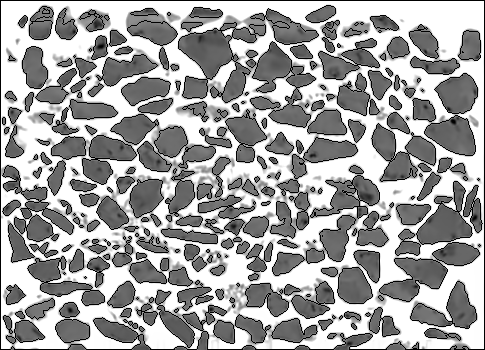

In [ ]:
#extract contures #RETR_LIST or #RETR_TREE

#cont_img1 = result.copy()
#cont_img1 =edg_img.copy()
cont_img1 =inv_img.copy()

retval, thresh = cv2.threshold(cont_img1,127, 255, 0)
#retval, thresh = cv2.threshold(cont_img1,127,200,cv2.THRESH_BINARY)

img_contours0, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(cont_img1, img_contours0, -1, (0, 0, 0))

#remove the image boundry contour
img_contours0 = img_contours0[:-1] 


cv2_imshow(cont_img1)


In [ ]:
len(img_contours0)

377

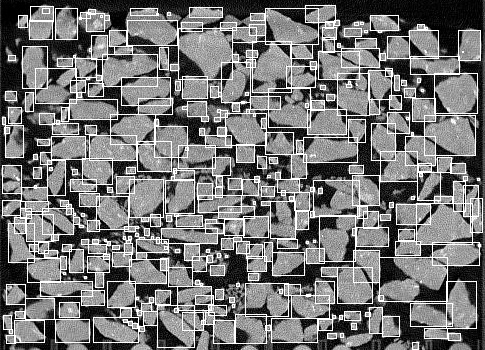

In [ ]:
#for loop to draw box on all contours

img_cc=gray_img.copy()
Square_list=[]

for i in range (0, len(img_contours0)):
  list1= img_contours0[i]

  max = np.amax(list1, axis=0)
  min = np.amin(list1, axis=0)
  maxL = max.tolist() + min.tolist()
  cc = (maxL[0][0],maxL[1][1])
  cp = (maxL[1][0],maxL[0][1])
  temp = [cc,cp]
  Square_list.append(temp)
	
  cv2.rectangle(img_cc,cc, cp, (255, 255, 251))
  #cv2.rectangle(img_cc,max,min, (255, 255, 251))
cv2_imshow(img_cc)

In [ ]:
#img_contours
print('Number of of contours found ' +str(len(img_contours0)) + '\n')

# lets assue that; countours  == a boundry of partical
#thefore no of particles 

print('Number of particles  ' +str(len(img_contours0)))

Number of of contours found 377

Number of particles  377


In [ ]:
#Calculate the area of contours

c_Area=[]

for i in range(len(img_contours0)):
  area = cv2.contourArea(img_contours0[i])
  c_Area.append(area)

#c_Area


In [ ]:
# Calculate Contour Perimeter

c_Peri=[]

for i in range(len(img_contours0)):
  perimeter = cv2.arcLength(img_contours0[i],True)
  c_Peri.append(perimeter)
#c_Peri

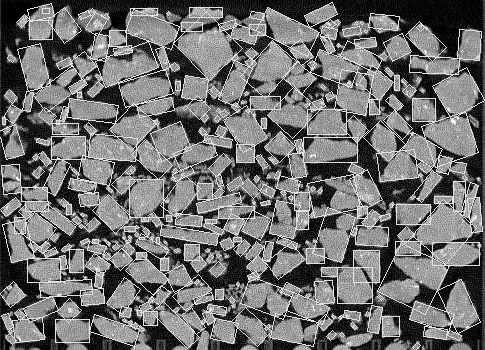

Detected particles


In [ ]:
# Find and draw rotated rectangle

Round_rec = gray_img.copy()

Rect_area =[]

for i in range(len(img_contours0)):
  rect = cv2.minAreaRect(img_contours0[i])
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  cv2.drawContours(Round_rec,[box],0,(225,225,255),1)

  # obtain area of rotated rect.
  R_area = cv2.contourArea(box)
  Rect_area.append(R_area)
cv2_imshow(Round_rec)
print('Detected particles')

## Following data were extrcted
1. No of contours/ particles detected = 377
2.The area of particles (using contour area), find in c_Area list
3.The perimeter of particles (using contour perimeter), find in c_Peri list
4.The area of  bounding rectangle with minimum area around particles (using contour otated Rectangle and area), find in Rect_area list

##Parameter Calclulation

In [ ]:
#Cacl circularity , ircularity (or isoperimetric quotient), a function of the perimeter P and the area A: C = 4πA/P^2 (Sphericity S)
#no need for unit conversion

c_circ =[]

for i in range(len(img_contours0)):
  if c_Peri[i] ==0 :
     circularity = 'n/A'
  else: 
    Sq_para =(c_Peri[i])*(c_Peri[i])
    circularity = (4*(np.pi)* c_Area[i])/(Sq_para)
  c_circ.append(circularity)


### the particles particle size can measured in follwoing methods

Particle size parameters AKA article size descriptors

1.   Equivalent Circular Perimeter Diameter (EqPD)
2.   equivalent Circular Area Diameter (EqAD)
3.   Length L and Width W
5. Minimum Enclosing Circle diameter 






In [ ]:
# Calc Equivalent Circular Perimeter Diameter, EqPD = Perimeter/π
# unit conversion 1mm =1.82px 
EqPD =[]

for i in range(len(img_contours0)):
  Temp = (c_Peri[i]/(np.pi))
  EQP_Diameter = Temp/1.82
  EqPD.append(EQP_Diameter)

In [ ]:
# Calc Equivalent Circular Area Diameter, EqAD = 2*√(Area/π)
#unit conversion 1mm =1.82px 
EqAD =[]

for i in range(len(img_contours0)):
  Temp= 2*(math.sqrt(c_Area[i]/(np.pi)))
  EQA_Diameter = Temp/1.82
  EqAD.append(EQA_Diameter)


In [ ]:
#Calc width and height Using bounding rectangle ,width and Length
# unit conversion 1mm =1.82px 
Wid_Len =[]

for i in range(len(img_contours0)):
  rect = cv2.minAreaRect(img_contours0[i])
  Wid_Len.append(rect[1]) 

#Append width and length separate lists 

Width =[]
Length =[]

for i in range(len(Wid_Len)):
  if Wid_Len[i][0] > Wid_Len[i][1] :
    W_pix = ((Wid_Len[i][1])/1.82)
    L_pix =((Wid_Len[i][0])/1.82)
    Width.append(W_pix)
    Length.append(L_pix)
  else:
    W_pix = ((Wid_Len[i][0])/1.82)
    L_pix =((Wid_Len[i][1])/1.82)
    Width.append(W_pix)
    Length.append(L_pix)



In [ ]:
#Revised
#Minimum Enclosing Circle, circle which completely covers the object with minimum area
# unit conversion 1mm =1.82px 
MiEnD =[]
for i in range(len(img_contours0)):
  (x,y),radius = cv2.minEnclosingCircle(img_contours0[i])
  temp_r = 2*radius  #in px
  Min_enc_Dia = temp_r/1.82
  MiEnD.append(Min_enc_Dia)

## Following data were extrcted (377)

1.   Equivalent Circular Perimeter Diameter (EqPD) record in list **EqPD**
2.   Equivalent Circular Area Diameter (EqAD) record in list **EqAD**
3.   Length L and Width W record in list **Wid_Len** ( separately in lists of width and Length)
4. Minimum Enclosing Circle diameter record in list **MiEnD**
5. Sphericity of Particles are in list of **c_circ**


##Visualizing data

In [ ]:
#Generate table contatining all extracted data

lst0 = c_circ
lst1 = EqPD
lst2 = EqAD
lst3 = Wid_Len
lst31 = Length
lst32 =Width
lst4 = MiEnD

percentile_list = pd.DataFrame(
    {'sphericity':lst0,   'Equivalent Circular Perimeter Diameter(mm)': lst1,
     'Equivalent Circular Area Diameter (mm)': lst2,
     'Length and Width (px)': lst3,'Length (mm)':lst31 ,'Width (mm)':lst32,
     'Minimum Enclosing Circle diameter (mm)':lst4
    })

#percentile_list
#The generated data copied to .csv

In [ ]:
#Histrogram saving fuction
def hisrogram_save(figname):
  fold = ('/content/drive/MyDrive/PlantPerform_A01/Final/Grap_')
  format = '.jpg'
  dir=fold+figname+format
  #print(dir)
  plt.savefig(dir,dpi=300)

In [ ]:
#define fuction to display histrogrames
def Histro(datalist,colrs,title,xlab,ylab,figname):
  size, scale = 1000, 10
  commutes = pd.Series(datalist, dtype='float')

  #bin = np.linspace(0, 80, 30)
  bin=40

  commutes.plot.hist(grid=True, bins=bin, rwidth=0.9,color=colrs)
  plt.title(title)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.grid(axis='y', alpha=0.75)
  hisrogram_save(figname)
  plt.show()

In [ ]:
#remove 'n/A' in c_circ
c_circ_r = np.array(c_circ)
c_circ_r = np.where(c_circ_r == 'n/A', 0, c_circ_r)
c_circ_r=list(np.array(c_circ_r).astype(float))
#np.array(c_circ_r,dtype=float)
#c_circ_r= c_circ_r.tolist()


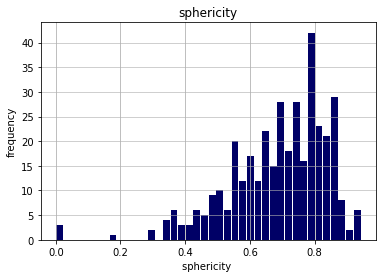

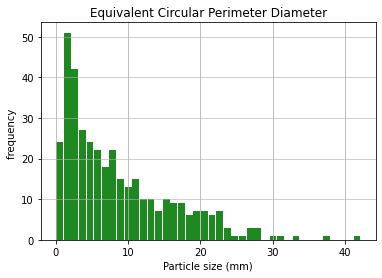

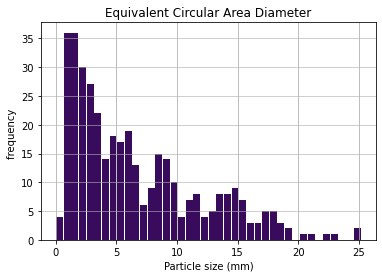

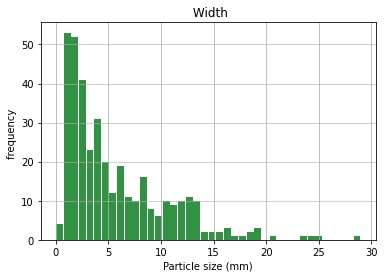

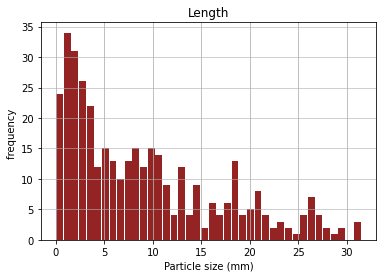

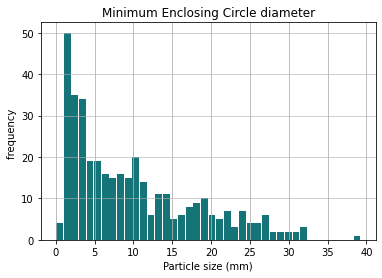

In [ ]:

#Visualize data

Data_list = [c_circ_r,EqPD ,EqAD ,Width, Length  , MiEnD]
Titl_list = ['sphericity','Equivalent Circular Perimeter Diameter', 'Equivalent Circular Area Diameter',' Width','Length','Minimum Enclosing Circle diameter']
colour_list = ['#000066','#1D8920','#390B5C','#319244','#942323','#157477']
xlab_list = ['sphericity ','Particle size (mm)','Particle size (mm)','Particle size (mm)','Particle size (mm)','Particle size (mm)']
ylab_list = ['frequency','frequency ','frequency ','frequency ','frequency ','frequency ']
Graph = ['sphericity','EqP_Dia', 'EqA_Dia',' Width','Length','MinEnCir_Dia']

for i in range(0,6):
  #i=0
  Histro(Data_list[i],colour_list[i], Titl_list[i], xlab_list[i], ylab_list[i], Graph[i])
  



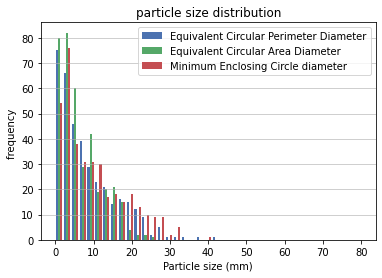

In [ ]:
# Three datas in one hisrogram

plt.style.use('seaborn-deep')

x = EqPD
y = EqAD
z = MiEnD
bins = np.linspace(0, 80, 40)

plt.hist([x, y,z], bins, label=['Equivalent Circular Perimeter Diameter', 'Equivalent Circular Area Diameter','Minimum Enclosing Circle diameter'])
plt.title('particle size distribution')
plt.legend(loc='upper right')
plt.xlabel('Particle size (mm)')
plt.ylabel('frequency ')
plt.grid(axis='y', alpha=0.75)

plt.savefig('/content/drive/MyDrive/PlantPerform_A01/Final/PDS.jpg',dpi=300)



In [ ]:
#Revised
#calculate mean,sd and ranges


Data_list = [c_circ_r,EqPD ,EqAD ,Width, Length  , MiEnD]
Titl_list0 = ['sphericity','Equivalent Circular Perimeter Diameter', 'Equivalent Circular Area Diameter',' Width','Length','Minimum Enclosing Circle diameter']
Para_lable0 = ["mean","Standard daviation",'Min','Max']
para_data =[]
for i in range(len(Data_list)):

  lit = Data_list[i]
  lit= (np.array(lit))
  mean = np.mean(lit)
  sd=np.std(lit, axis = None)
  max = np.max(lit)
  min = np.min(lit)
  temp=[mean,sd,min,max]

  para_data.append(temp)


In [ ]:
#Revised
#Generate table contatining results


percentile_list = pd.DataFrame(
    {'Parameter':Para_lable0 ,'sphericity':para_data[0],   'Equivalent Circular Perimeter Diameter(mm)':para_data[1],
     'Equivalent Circular Area Diameter (mm)':para_data[2],
     'Length (mm)':para_data[3] ,'Width (mm)':para_data[4],
     'Minimum Enclosing Circle diameter (mm)':para_data[5]
    })
percentile_list

,Parameter,sphericity,Equivalent Circular Perimeter Diameter(mm),Equivalent Circular Area Diameter (mm),Length (mm),Width (mm),Minimum Enclosing Circle diameter (mm)
0,mean,0.686209,8.572380,6.652214,5.629091,9.208779,9.812927
1,Standard daviation,0.153355,7.445042,5.308993,4.877245,7.754928,8.086886
2,Min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000110
3,Max,0.943271,42.173801,25.184054,28.995166,31.460844,39.269491


##Saving code and images

In [ ]:
#Save images

image_Name = ['Blured_img','Detected_edges_img','Adjusted_exposure_img','Noise_reduced_PP_img','Detected_Contours','Straight_Bound_recangles','Rotated_bounded_rectangles']
image_list =[blur_img,edg_img,result,inv_img,cont_img1,img_cc,Round_rec]

#for i in range(len(image_list)):
  #cv2_imshow(image_list[i])
  
  #fold = ('/content/drive/MyDrive/PlantPerform_A01/Final/fig_')
  #format = '.jpg'
  #dir=fold+image_Name[i]+format
  #cv2.imwrite(dir,image_list[i])
  #print(dir)

In [ ]:
#Print the colab Notebook

#!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
#from colab_pdf import colab_pdf
#colab_pdf('GroupD-PP_As1.ipynb')

In [ ]:
CSV = pd.read_csv('/content/drive/MyDrive/PlantPerform_A01/PSD_mm.csv')  

CSV.to_html('/content/drive/MyDrive/PlantPerform_A01/PSD_mm.html') 

#pdfkit.from_file('/content/drive/MyDrive/PlantPerform_A01/PSD_mm.html', '/content/drive/MyDrive/PlantPerform_A01/PSD_mm.pdf')